# YOLOV3目标检测-摄像头实时检测

YOLOV3算法精讲与论文逐句精读：同济子豪兄：https://space.bilibili.com/1900783

不注明出处的转载视为侵权。

2021-08-28

In [11]:
import cv2
import numpy as np
# 导入python绘图matplotlib
import matplotlib.pyplot as plt
# 使用ipython的魔法方法，将绘制出的图像直接嵌入在notebook单元格中
%matplotlib inline
# 定义可视化图像函数
def look_img(img):
    '''opencv读入图像格式为BGR，matplotlib可视化格式为RGB，因此需将BGR转RGB'''
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB)
    plt.show()

# 导入预训练YOLOV3模型
net = cv2.dnn.readNet('yolov3.weights','yolov3.cfg')
# 获取三个尺度输出层的名称
layersNames = net.getLayerNames()
# output_layers_names = [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]
output_layers_names =  [layersNames[i-1] for i in net.getUnconnectedOutLayers()]

# 导入COCO数据集80个类别
with open('coco.names','r') as f:
    classes = f.read().splitlines()

In [12]:
CONF_THRES = 0.2 # 指定置信度阈值，阈值越大，置信度过滤越强
NMS_THRES = 0.4 # 指定NMS阈值，阈值越小，NMS越强

# 处理单帧函数

In [13]:
# 处理帧函数
def process_frame(img):
    # 获取图像宽高
    height, width, _ = img.shape
    blob = cv2.dnn.blobFromImage(img, 1/255, (416,416), (0,0,0), swapRB=True, crop=False)
    net.setInput(blob)
    # 前向推断
    prediction = net.forward(output_layers_names)

    # 从三个尺度输出结果中解析所有预测框信息
    # 存放预测框坐标
    boxes = []
    # 存放置信度
    objectness = []
    # 存放类别概率
    class_probs = []
    # 存放预测框类别索引号
    class_ids = []
    # 存放预测框类别名称
    class_names = []

    for scale in prediction: # 遍历三种尺度
        for bbox in scale: # 遍历每个预测框
            obj = bbox[4] # 获取该预测框的confidence（objectness）
            class_scores = bbox[5:] # 获取该预测框在COCO数据集80个类别的概率
            class_id = np.argmax(class_scores) # 获取概率最高类别的索引号
            class_name = classes[class_id] # 获取概率最高类别的名称
            class_prob = class_scores[class_id] # 获取概率最高类别的概率

            # 获取预测框中心点坐标、预测框宽高
            center_x = int(bbox[0] * width)
            center_y = int(bbox[1] * height)
            w = int(bbox[2] * width)
            h = int(bbox[3] * height)
            # 计算预测框左上角坐标
            x = int(center_x - w/2)
            y = int(center_y - h/2)

            # 将每个预测框的结果存放至上面的列表中
            boxes.append([x, y, w, h])
            objectness.append(float(obj))
            class_ids.append(class_id)
            class_names.append(class_name)
            class_probs.append(class_prob)
            
    # 将预测框置信度objectness与各类别置信度class_pred相乘，获得最终该预测框的置信度confidence
    confidences = np.array(class_probs) * np.array(objectness)

    # 置信度过滤、非极大值抑制抑制NMS
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, CONF_THRES, NMS_THRES)
    # 随机给每个预测框生成一种颜色
    colors = [[255,0,255],[0,0,255],[0,255,255],[0,255,0],[255,255,0],[255,0,0],[180,187,28],[223,155,6],[94,218,121],[139,0,0],[77,169,10],[29,123,243],[66,77,229],[1,240,255],[140,47,240],[31,41,81],[29,123,243],[16,144,247],[151,57,224]]

    # 遍历留下的每一个预测框，可视化
    for i in indexes.flatten():
        # 获取坐标
        x, y, w, h = boxes[i]
        # 获取置信度
        confidence = str(round(confidences[i],2))
        # 获取颜色，画框
        color = colors[i%len(colors)]
        cv2.rectangle(img, (x,y), (x+w,y+h), color, 5)

        # 写类别名称和置信度
        # 图片，添加的文字，左上角坐标，字体，字体大小，颜色，字体粗细
        string = '{} {}'.format(class_names[i], confidence)
        cv2.putText(img, string, (x, y+20), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255),5)
    
    return img

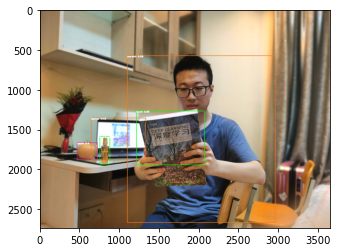

In [14]:
# 测试一下函数
img = cv2.imread('test.jpg')
img = process_frame(img)
look_img(img)

# 调用摄像头获取每帧（模板）

In [15]:
# 调用摄像头逐帧实时处理模板
# 不需修改任何代码，只需修改process_frame函数即可
# 同济子豪兄 2021-7-8

# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

# 无限循环，直到break被触发
while cap.isOpened():
    # 获取画面
    success, frame = cap.read()
    if not success:
        print('Error')
        break
    start_time = time.time()
    
    ## !!!处理帧函数
    frame = process_frame(frame)
    
    # 展示处理后的三通道图像
    cv2.imshow('my_window',frame)

    if cv2.waitKey(1) in [ord('q'),27]: # 按键盘上的q或esc退出（在英文输入法下）
        break
    
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()